In [4]:
# ODEV3_GRUP9.ipynb
# Frequency Domain Image Processing

## Introduction
#This notebook demonstrates various frequency domain filtering operations on a synthetic grayscale image. We'll cover:
#1. Creating a synthetic image
#2. High-pass and low-pass filtering
#3. Adding and removing periodic noise
#4. Analyzing results in both spatial and frequency domains

## 1. Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cv2
from scipy import fftpack
from scipy.ndimage import gaussian_filter

<ipython-input-5-f9e9d43b9fbb>:18: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.subplot(122), plt.hist(image.ravel(), 256, [0,256]), plt.title('Histogram')


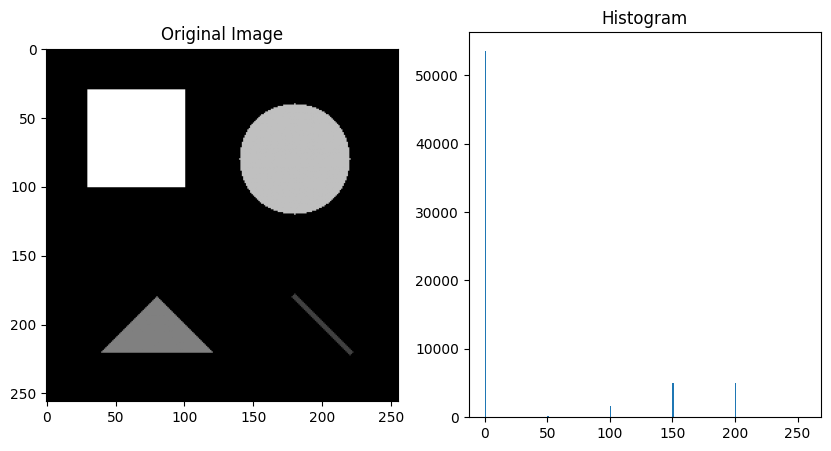

In [5]:
# Create blank image
image = np.zeros((256, 256), dtype=np.uint8)

# Draw geometric shapes
# Rectangle
image = cv2.rectangle(image, (30, 30), (100, 100), 200, -1)
# Circle
image = cv2.circle(image, (180, 80), 40, 150, -1)
# Triangle
pts = np.array([[80, 180], [120, 220], [40, 220]])
image = cv2.fillPoly(image, [pts], 100)
# Diagonal line
image = cv2.line(image, (180, 180), (220, 220), 50, 3)

# Display
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.hist(image.ravel(), 256, [0,256]), plt.title('Histogram')
plt.show()

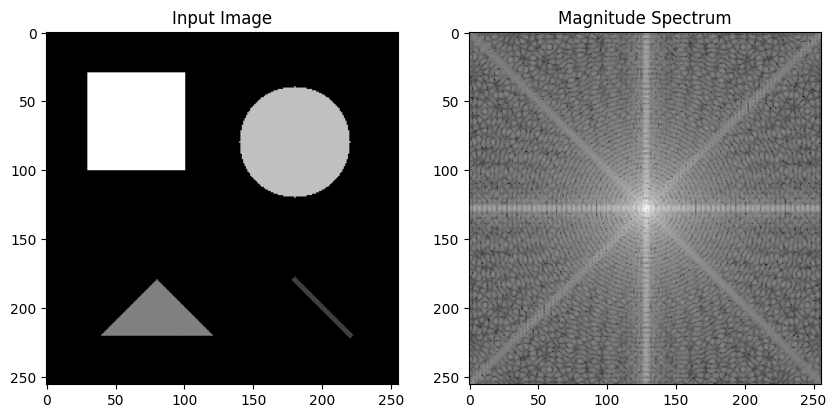

In [6]:
# Compute 2D FFT
f = fftpack.fft2(image)
fshift = fftpack.fftshift(f)  # Shift zero frequency to center
magnitude_spectrum = 20*np.log(np.abs(fshift))

# Display
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Input Image')
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray'),
plt.title('Magnitude Spectrum')
plt.show()

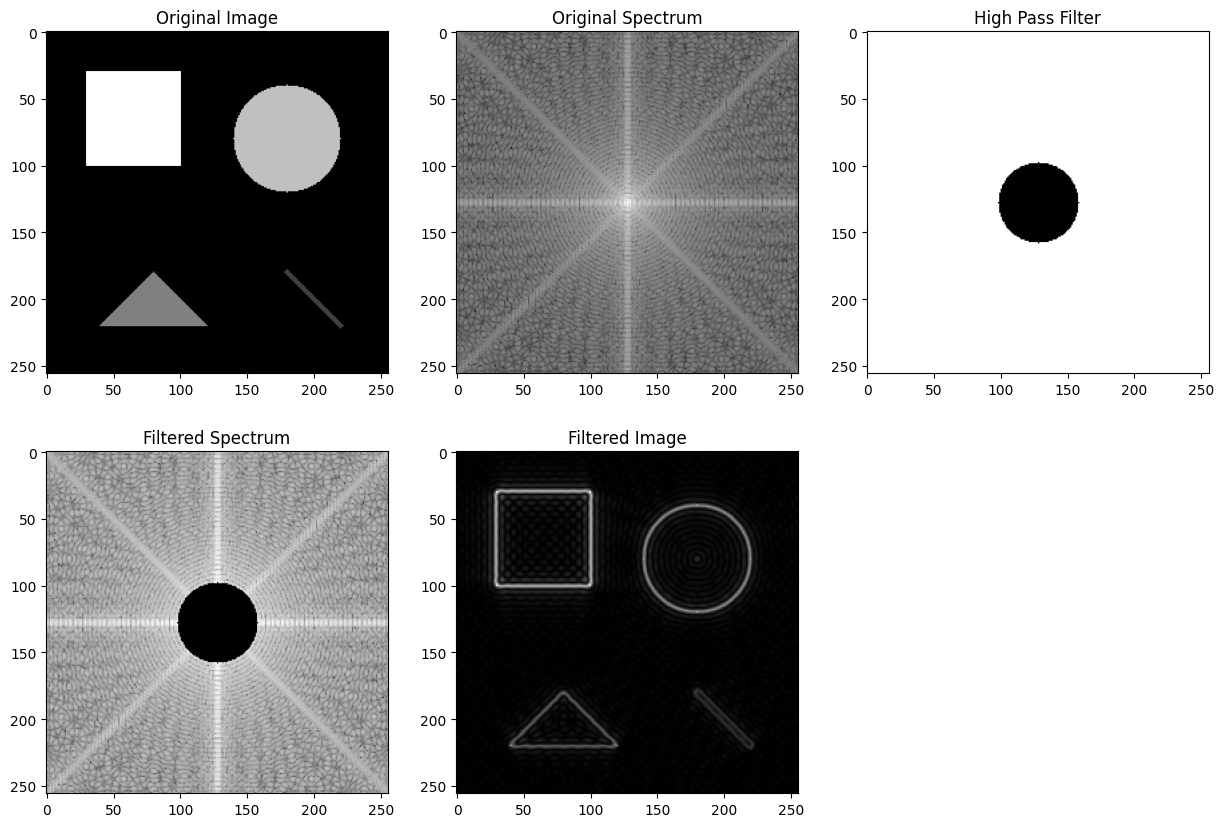

In [7]:
def high_pass_filter(image, cutoff):
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2

    # Create mask first with 1s
    mask = np.ones((rows, cols), np.uint8)
    # Set center region to 0
    r = cutoff
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
    mask[mask_area] = 0

    return mask

# Apply high-pass filter
cutoff_freq = 30
hpf_mask = high_pass_filter(image, cutoff_freq)

# Filter the spectrum
fshift_filtered = fshift * hpf_mask
magnitude_spectrum_hpf = 20*np.log(np.abs(fshift_filtered)+1)

# Inverse FFT
f_ishift = fftpack.ifftshift(fshift_filtered)
img_back = fftpack.ifft2(f_ishift)
img_back = np.abs(img_back)

# Display results
plt.figure(figsize=(15,10))
plt.subplot(231), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(232), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('Original Spectrum')
plt.subplot(233), plt.imshow(hpf_mask, cmap='gray'), plt.title('High Pass Filter')
plt.subplot(234), plt.imshow(magnitude_spectrum_hpf, cmap='gray'), plt.title('Filtered Spectrum')
plt.subplot(235), plt.imshow(img_back, cmap='gray'), plt.title('Filtered Image')
plt.show()

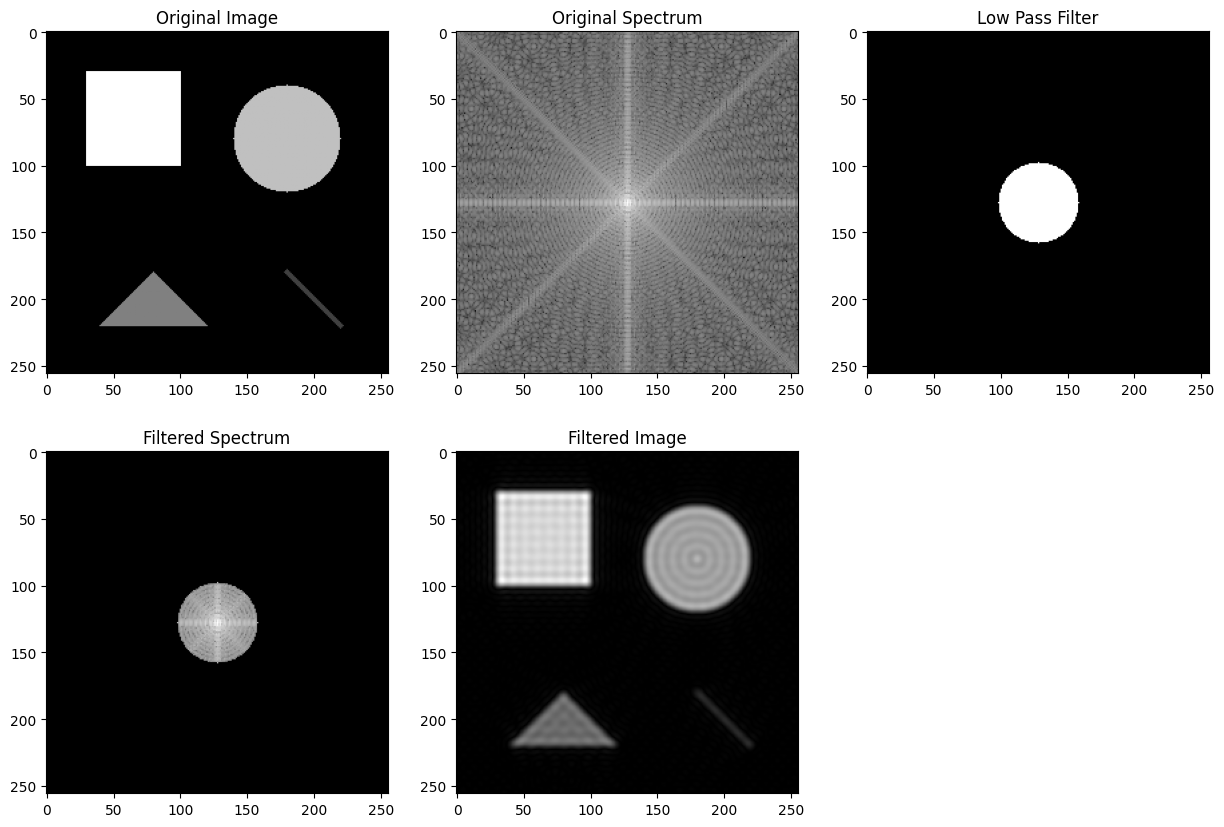

In [8]:
def low_pass_filter(image, cutoff):
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2

    # Create mask first with 0s
    mask = np.zeros((rows, cols), np.uint8)
    # Set center region to 1
    r = cutoff
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
    mask[mask_area] = 1

    return mask

# Apply low-pass filter
cutoff_freq = 30
lpf_mask = low_pass_filter(image, cutoff_freq)

# Filter the spectrum
fshift_filtered = fshift * lpf_mask
magnitude_spectrum_lpf = 20*np.log(np.abs(fshift_filtered)+1)

# Inverse FFT
f_ishift = fftpack.ifftshift(fshift_filtered)
img_back = fftpack.ifft2(f_ishift)
img_back = np.abs(img_back)

# Display results
plt.figure(figsize=(15,10))
plt.subplot(231), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(232), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('Original Spectrum')
plt.subplot(233), plt.imshow(lpf_mask, cmap='gray'), plt.title('Low Pass Filter')
plt.subplot(234), plt.imshow(magnitude_spectrum_lpf, cmap='gray'), plt.title('Filtered Spectrum')
plt.subplot(235), plt.imshow(img_back, cmap='gray'), plt.title('Filtered Image')
plt.show()

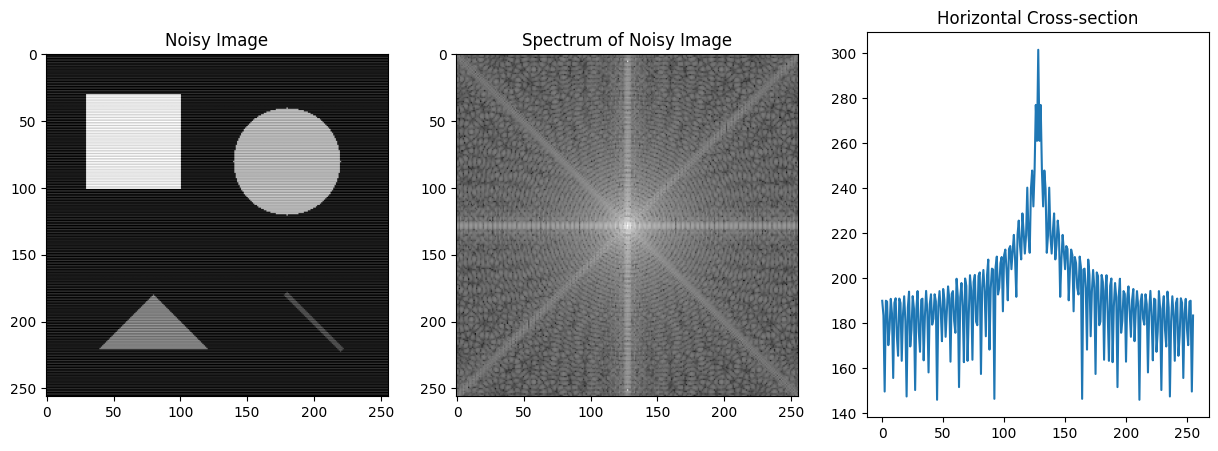

In [9]:
# Let's assume sum of school numbers is 123 (replace with your actual sum)
noise_freq = 123

# Create horizontal cosine noise
x = np.arange(256)
noise = np.outer(np.cos(2 * np.pi * noise_freq * x / 256), np.ones(256))
noise = ((noise + 1) / 2 * 50)  # Scale to 0-50 range

# Add noise to image
noisy_image = image + noise
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

# Compute spectrum of noisy image
f_noisy = fftpack.fft2(noisy_image)
fshift_noisy = fftpack.fftshift(f_noisy)
magnitude_spectrum_noisy = 20*np.log(np.abs(fshift_noisy)+1)

# Display
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(noisy_image, cmap='gray'), plt.title('Noisy Image')
plt.subplot(132), plt.imshow(magnitude_spectrum_noisy, cmap='gray'),
plt.title('Spectrum of Noisy Image')
plt.subplot(133), plt.plot(magnitude_spectrum_noisy[128]),
plt.title('Horizontal Cross-section')
plt.show()

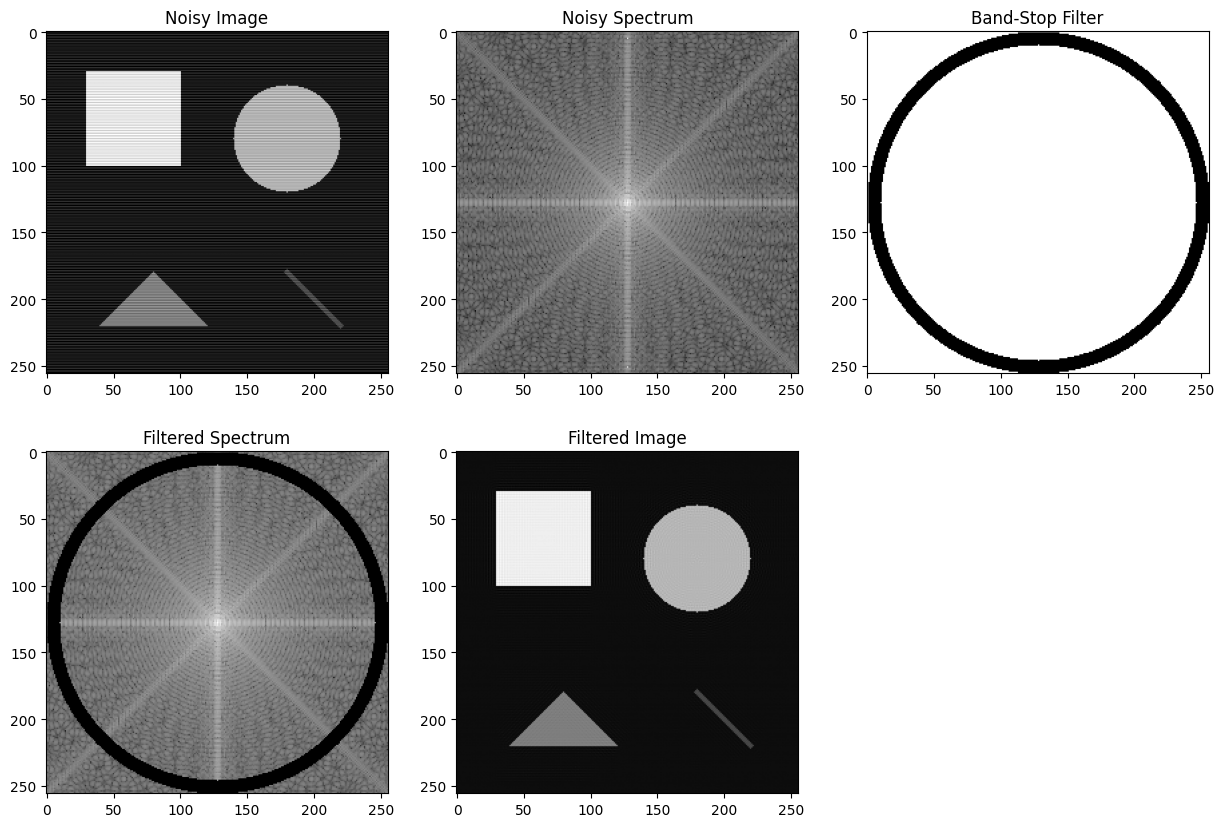

PSNR between original and noisy image: 28.88 dB
PSNR between original and filtered image: 28.34 dB


In [10]:
def band_stop_filter(image, freq, bandwidth):
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2

    # Create mask with 1s
    mask = np.ones((rows, cols), np.uint8)

    # Set frequency bands to 0
    for i in range(rows):
        for j in range(cols):
            dist = np.sqrt((i - crow)**2 + (j - ccol)**2)
            if (dist > freq - bandwidth/2) and (dist < freq + bandwidth/2):
                mask[i,j] = 0

    return mask

# Apply band-stop filter
bsf_mask = band_stop_filter(noisy_image, noise_freq, 10)

# Filter the spectrum
fshift_filtered = fshift_noisy * bsf_mask
magnitude_spectrum_filtered = 20*np.log(np.abs(fshift_filtered)+1)

# Inverse FFT
f_ishift = fftpack.ifftshift(fshift_filtered)
img_back = fftpack.ifft2(f_ishift)
img_back = np.abs(img_back).astype(np.uint8)

# Display results
plt.figure(figsize=(15,10))
plt.subplot(231), plt.imshow(noisy_image, cmap='gray'), plt.title('Noisy Image')
plt.subplot(232), plt.imshow(magnitude_spectrum_noisy, cmap='gray'),
plt.title('Noisy Spectrum')
plt.subplot(233), plt.imshow(bsf_mask, cmap='gray'), plt.title('Band-Stop Filter')
plt.subplot(234), plt.imshow(magnitude_spectrum_filtered, cmap='gray'),
plt.title('Filtered Spectrum')
plt.subplot(235), plt.imshow(img_back, cmap='gray'), plt.title('Filtered Image')
plt.show()

# Calculate PSNR for quality assessment
def psnr(original, filtered):
    mse = np.mean((original - filtered) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

original_psnr = psnr(image, noisy_image)
filtered_psnr = psnr(image, img_back)

print(f"PSNR between original and noisy image: {original_psnr:.2f} dB")
print(f"PSNR between original and filtered image: {filtered_psnr:.2f} dB")